In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
inspector = inspect(engine)
# Get a list of column names and types
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

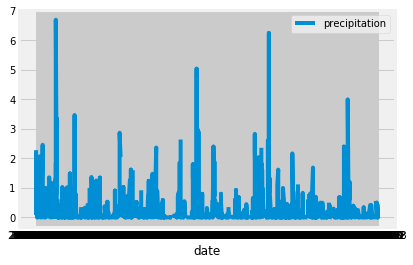

In [30]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
import datetime as dt
sel = [Measurement.date,
      Measurement.prcp
      ]

#Calculate the date 1 year ago from the last data point in the database
cli_latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Perform a query to retrieve the data and precipitation scores
last_twe_prec = session.query(Measurement.date,Measurement.prcp).\
     filter(Measurement.date > (dt.date(2017,8,23) - dt.timedelta(days = 365))).\
     order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column          
measure_df = pd.DataFrame(last_twe_prec, columns = ["date","precipitation"])
measure_df.set_index('date', inplace=True)

# Sort the dataframe by date
sort_m_df = measure_df.sort_values(['date'])
measure_df.head(10)

# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(sort_m_df)
plt.xlabel("date")
plt.legend(["precipitation"])

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measure_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(func.count(Measurement.station)).all()
num_stations

[(19550)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_sel = [Measurement.station,
                func.count(Measurement.station)
               ]
#groupby station and count
grp_stations = session.query(*stations_sel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

grp_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

#lowest temperature query
low_temp = session.query(Measurement.station,Measurement.tobs).order_by(Measurement.tobs).first()

#highest temperature query
high_temp = session.query(Measurement.station,Measurement.tobs).order_by(Measurement.tobs.desc()).first()

#average temp most active station (USC00519281)
avg_most_act_station = session.query(Measurement.station, 
                                     func.avg(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
avg_most_act_station

('USC00519281', 71.66378066378067)

In [18]:
# Choose the station with the highest number of temperature observations.
#USC00519281
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_twe = session.query(Measurement.station,
             Measurement.date,
             Measurement.tobs).filter(Measurement.date > (dt.date(2017,8,23) - dt.timedelta(days = 365))).filter(Measurement.station == "USC00519281").all()

In [19]:
last_twe_date = [x[1] for x in last_twe]
last_twe_temp = [int(x[2]) for x in last_twe]


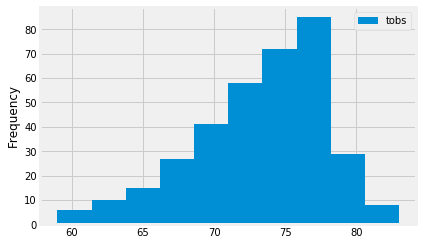

In [29]:
plt.hist(last_twe_temp)
plt.ylabel("Frequency")
plt.legend(["tobs"])

![precipitation](Images/station-histogram.png)

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
lastyear_calc = calc_temps('2016-08-23','2017-08-23')
lastyear_calc

[(58.0, 74.59058295964125, 87.0)]

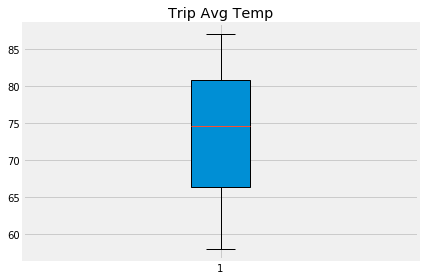

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()

x = range(len(lastyear_calc))
ax.boxplot(lastyear_calc, patch_artist=True)
ax.set_title('Trip Avg Temp')
fig.tight_layout()
plt.show()


In [31]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
r_per_stat = session.query(Station.station,
                           Station.name,
                           Station.latitude,
                           Station.longitude,
                           Station.elevation,
                           Measurement.prcp
                          ).filter(Measurement.station == Station.station).filter(Measurement.date > (dt.date(2017,8,23) - dt.timedelta(days = 365))).order_by(Measurement.prcp.desc()).all()

## Optional Challenge Assignment

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [159]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals_one = daily_normals("01-01")
normals_two = daily_normals("10-01")
# Set the start and end date of the trip
start_d = dt.datetime.strptime( "01-01-2019", "%m-%d-%Y")
end_d = dt.datetime.strptime( "10-01-2019", "%m-%d-%Y")
# Use the start and end date to create a range of dates
date_range = [start_d + dt.timedelta(days=x) for x in range(0, (end_d-start_d).days)]
date_range
# Stip off the year and save a list of %m-%d strings
date_range_clean = [date_range[x].strftime("%m-%d") for x in range(0,len(date_range))]
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []
for x in range(0,len(date_range_clean)):
    normals_list.extend(daily_normals(date_range_clean[x]))
date_range_clean

['01-01',
 '01-02',
 '01-03',
 '01-04',
 '01-05',
 '01-06',
 '01-07',
 '01-08',
 '01-09',
 '01-10',
 '01-11',
 '01-12',
 '01-13',
 '01-14',
 '01-15',
 '01-16',
 '01-17',
 '01-18',
 '01-19',
 '01-20',
 '01-21',
 '01-22',
 '01-23',
 '01-24',
 '01-25',
 '01-26',
 '01-27',
 '01-28',
 '01-29',
 '01-30',
 '01-31',
 '02-01',
 '02-02',
 '02-03',
 '02-04',
 '02-05',
 '02-06',
 '02-07',
 '02-08',
 '02-09',
 '02-10',
 '02-11',
 '02-12',
 '02-13',
 '02-14',
 '02-15',
 '02-16',
 '02-17',
 '02-18',
 '02-19',
 '02-20',
 '02-21',
 '02-22',
 '02-23',
 '02-24',
 '02-25',
 '02-26',
 '02-27',
 '02-28',
 '03-01',
 '03-02',
 '03-03',
 '03-04',
 '03-05',
 '03-06',
 '03-07',
 '03-08',
 '03-09',
 '03-10',
 '03-11',
 '03-12',
 '03-13',
 '03-14',
 '03-15',
 '03-16',
 '03-17',
 '03-18',
 '03-19',
 '03-20',
 '03-21',
 '03-22',
 '03-23',
 '03-24',
 '03-25',
 '03-26',
 '03-27',
 '03-28',
 '03-29',
 '03-30',
 '03-31',
 '04-01',
 '04-02',
 '04-03',
 '04-04',
 '04-05',
 '04-06',
 '04-07',
 '04-08',
 '04-09',
 '04-10',


(61.0, 71.875, 79.0)

In [160]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df ={}
normals_df = pd.DataFrame({
                            "tmin": [item[0] for item in normals_list],
                            "t_avg": [item[1] for item in normals_list],
                            "tmax": [item[2] for item in normals_list]
})
normals_df["date"] = date_range_clean
normals_df.set_index("date")

,tmin,t_avg,tmax
date,,,
01-01,62.0,69.153846,77.0
01-02,60.0,69.396226,77.0
01-03,62.0,68.909091,77.0
01-04,58.0,70.000000,76.0
01-05,56.0,67.964286,76.0
01-06,61.0,68.964912,76.0
01-07,57.0,68.543860,76.0
01-08,57.0,67.160714,75.0
01-09,58.0,67.929825,78.0


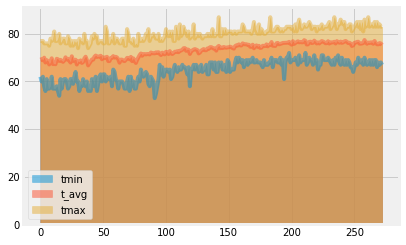

In [161]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area',stacked=False)